# B regressor final training

## Import

### Import modules

In [1]:
from __future__ import division ,print_function

import theano
import statsmodels.api as sm
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GaussianNoise, BatchNormalization, Merge, GaussianDropout
from keras.layers.advanced_activations import ELU, PReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from keras.models import load_model
from keras import regularizers
from keras import backend as K

import theano.tensor as T
from scipy.stats import ks_2samp
import scipy.misc
import seaborn as sns
sns.set_style("white")
import os
from sklearn.pipeline import Pipeline
import json
import glob
import pickle
from sklearn.externals import joblib
import sys
sys.path.append('../../../../modules')
from MPPlot import *
from Processors import *

/home/goncalo/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.


### Import data
Here just looking at mu tau_h b b final-state

In [2]:
mode = "mu_tau_b_b"
loc = '../../../../../data_n/'
SignalData = []
BackgroundData = []

energies = [260, 270, 280, 300, 320, 400, 500, 550, 600 ,700]
backgrounds = ['TT' , 'WJetsToLNu']
Data = np.concatenate((energies,backgrounds))

def backgroundName(background):
    if background == 'TT':
        return loc + 'TT_TuneCUETP8M1_13TeV-powheg-pythia8_2.csv'
    elif background == 'WJetsToLNu':
        return loc + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8.csv'

 #Load data from CSV files
for energy in energies:
    signaldata = pandas.read_csv(loc + "GluGluToRadionToHHTo2B2Tau_M-" + str(energy) +"_narrow_13TeV-madgraph.csv")
    signaldata['gen_label'] = energy
    SignalData.append(signaldata)


for back in backgrounds:
    backgroundData = pandas.read_csv(backgroundName(back))
    backgroundData['gen_label'] = back
    BackgroundData.append(backgroundData)    
     
    
signalData = SignalData[0]
for signal_data in SignalData[1:]:
    signalData = signalData.append(signal_data, ignore_index=True)
#drops columns with no headers
signalData.drop([x for x in signalData.columns if 'Unnamed' in x], axis=1, inplace=True)
#to distinguish signal from background we create a variable, gen_target and give it value 1 for signal
signalData['gen_target'] = pandas.Series(np.ones(signalData.size))

backgroundData = BackgroundData[0]
for background_data in BackgroundData[1:]:
    backgroundData = backgroundData.append(background_data, ignore_index=True)    
#drops columns with no headers
backgroundData.drop([x for x in backgroundData.columns if 'Unnamed' in x], axis=1, inplace=True)    
#and value 0 for background
backgroundData['gen_target'] = pandas.Series(np.zeros(backgroundData.size))

print("Samples contains {0} signal events and {1} background events".format(len(signalData), len(backgroundData)))
print("{} events in total".format(len(signalData)+len(backgroundData)))
data = signalData.append(backgroundData, ignore_index = True) #Combine into signal dataset


def abs_(x):
    if type(x) is float:
        return abs(x)
    else:
        return x

def cleanData(X):
    """
    Recives data and labels (X and y)
    
    Returns: X, y after removing points that would fail to convert to float32 
    """
    X.applymap(abs_)
    
    
    over  = (X > np.finfo(np.float32).max)
    under = (X < np.finfo(np.float32).min)
    selecting = pandas.Series(np.zeros(len(X)), dtype=np.bool)

    for label in over.columns:
        if label != 'gen_label':
            selecting = selecting | over[label] | under[label]
    
    
    X = X[np.logical_not(selecting)].reset_index(drop=True)#.values.astype('float32')
    
    return X
#some columns in data have points that fail to convert to float32, this fixes it
data = cleanData(data)

Samples contains 10417 signal events and 168053 background events
178470 events in total


### Process data and add new features

In [3]:
particles = ['t_0', 't_1', 'b_0', 'b_1', 'h_tt', 'h_bb', 'diH', 'gen_t_0', 'gen_t_1', 'gen_b_0' ,'gen_b_1']

for p in particles:
    moveToCartesian(data, p) #Move pT, eta, and phi to p_x, p_y, and p_z
    if(not str.startswith(p, "gen")):
        addEnergy(data, p) #Calculate energy and absolute momentum


moveToCartesian(data, 'mPT', False)  #Move Missing pT and phi to p_x and p_y
addAbsMom(data, 'mPT', False) #Calculate absolute missing transverse momentum
addMT(data, data['t_1_pT'], data['t_1_phi'], 't_1') #Calculate transverse mass of tau_mu
addHighLvl(data) #HighLvl variables, just a combination of various other variables
data['hl_mT'] = np.sqrt(2*data['t_1_pT']*data['mPT_pT']*(1-np.cos(deltaphi(data['t_1_phi'], data['mPT_phi']))))

### Separate Development and Validation Samples

In [4]:
sig_devIndeces, sig_valIndeces = \
                train_test_split([i for i in data[(data.gen_target == 1) & (data.gen_mctMatch == 1)].index.tolist()],
                                 test_size=0.2, random_state=1337)

    
devData = data.loc[sig_devIndeces].copy()
#devData = devData.append(data.loc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.loc[sig_valIndeces].copy()
valData = valData.append(data[data.gen_target == 0].copy(), ignore_index = True)
valData = valData.append(data[(data.gen_target == 1) & (data.gen_mctMatch == 0)].copy(), ignore_index = True)
sig = (valData.gen_target == 1) & (valData.gen_mctMatch == 1)
bkg = (valData.gen_target == 0)
sigMM = (valData.gen_target == 1) & (valData.gen_mctMatch == 0)

print("{} events for training, {} events for validation".format(len(devData), len(valData)))


3928 events for training, 174533 events for validation


### Specify variables

In [5]:
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures]

In [6]:
pTEtaPhi = [var for var in trainFeatures for x in ['pT', 'eta', 'phi'] if x in var]
other = [var for var in trainFeatures for x in ['prob'] if x in var] #a way to take out variables that don't work
trainFeatures = [var for var in trainFeatures if var not in pTEtaPhi+ other]
print(trainFeatures)

['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'h_tt_mass', 'h_tt_svFit_mass', 'h_bb_mass', 'diH_mass', 'diH_kinFit_mass', 'mT', 'hT', 'sT', 'centrality', 'eVis', 'sphericity', 'spherocity', 'aplanarity', 'aplanority', 'upsilon', 'dShape', 'sphericityEigen0', 'sphericityEigen1', 'sphericityEigen2', 'spherocityEigen0', 'spherocityEigen1', 'spherocityEigen2', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_tt_|p|', 'h_tt_E', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'h_bb_|p|', 'h_bb_E', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0',

In [27]:
shapes = [var for var in trainFeatures for x in ['aplan', 'dShape', 'spher', 'upsilon'] if x in var]
shapeFeatures = [var for var in trainFeatures if var in shapes]
eventKinematicFeatures = ['centrality', 'eVis', 'hT', 'sT','mT']
jetFeatures = [var for var in trainFeatures if 'Jet' in var and 'Jets' not in var]
multiplicityFeatures = ['nBJets', 'nJets', 'nPhotons', 'nTauJets']
hlFeatures = [var for var in trainFeatures if (str.startswith(var, "hl_"))]
recoFeatures = [var for var in trainFeatures if (str.startswith(var, "h_")) or (str.startswith(var, "diH_"))]
epFeatures = [var for var in trainFeatures if (str.endswith(var, "_E")) or (str.endswith(var, "_|p|"))]
fsFeatures =  [var for var in trainFeatures if var not in pTEtaPhi + recoFeatures + shapeFeatures]

In [28]:
set0 = [var for var in fsFeatures if var not in epFeatures]   
set1 = [var for var in fsFeatures]  
set2 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi + epFeatures] + ['hl_mT']
set3 = [var for var in fsFeatures + recoFeatures if var not in pTEtaPhi] + ['hl_mT']

## Specify options

In [29]:
regTrainFeatures = set3
regModel = 'model0'
normIn = True
normOut = True
pca = True
whiten = False
nSplits = 10
cvTests = True
ensembleSize = 10
ensembleMode = 'loss'
regTargetFeatures = ['gen_b_0_px', 'gen_b_0_py', 'gen_b_0_pz', 'gen_b_1_px', 'gen_b_1_py', 'gen_b_1_pz']
print ("\nTraining on", len(regTrainFeatures), "features:", [var for var in regTrainFeatures])
print ("\nRegressing to", len(regTargetFeatures), "features:", [var for var in regTargetFeatures])


Training on 125 features: ['t_0_mass', 't_1_mass', 'b_0_mass', 'b_0_csv', 'b_1_mass', 'b_1_csv', 'mT', 'hT', 'sT', 'centrality', 'eVis', 't_0_px', 't_0_py', 't_0_pz', 't_0_|p|', 't_0_E', 't_1_px', 't_1_py', 't_1_pz', 't_1_|p|', 't_1_E', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_0_|p|', 'b_0_E', 'b_1_px', 'b_1_py', 'b_1_pz', 'b_1_|p|', 'b_1_E', 'mPT_px', 'mPT_py', 'mPT_|p|', 't_1_mT', 'hl_dpx_b_0_b_1', 'hl_dpy_b_0_b_1', 'hl_dpz_b_0_b_1', 'hl_dpx_b_0_t_0', 'hl_dpy_b_0_t_0', 'hl_dpz_b_0_t_0', 'hl_dpx_b_0_t_1', 'hl_dpy_b_0_t_1', 'hl_dpz_b_0_t_1', 'hl_dpx_b_0_mPT', 'hl_dpy_b_0_mPT', 'hl_dpx_b_1_b_0', 'hl_dpy_b_1_b_0', 'hl_dpz_b_1_b_0', 'hl_dpx_b_1_t_0', 'hl_dpy_b_1_t_0', 'hl_dpz_b_1_t_0', 'hl_dpx_b_1_t_1', 'hl_dpy_b_1_t_1', 'hl_dpz_b_1_t_1', 'hl_dpx_b_1_mPT', 'hl_dpy_b_1_mPT', 'hl_dpx_t_0_b_0', 'hl_dpy_t_0_b_0', 'hl_dpz_t_0_b_0', 'hl_dpx_t_0_b_1', 'hl_dpy_t_0_b_1', 'hl_dpz_t_0_b_1', 'hl_dpx_t_0_t_1', 'hl_dpy_t_0_t_1', 'hl_dpz_t_0_t_1', 'hl_dpx_t_0_mPT', 'hl_dpy_t_0_mPT', 'hl_dpx_t_1_b_0', 'hl_dpy_t

## Define regressor

In [30]:
compileArgs = {'loss' : 'mse', 'optimizer' : 'nadam'}

def getRegressor():
    regModel = Sequential()
    regModel.add(Dense(200, input_dim=len(regTrainFeatures), kernel_initializer='he_normal', 
                       activation='selu'))
    regModel.add(GaussianNoise(1))
    #regModel.add(GaussianDropout(0.3))
    regModel.add(BatchNormalization())
    regModel.add(Dropout(0.2))
    regModel.add(Dense(200, kernel_initializer='he_normal', 
                       activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    #regModel.add(GaussianDropout(0.3))
    regModel.add(Dropout(0.2))
    regModel.add(Dense(200, kernel_initializer='he_normal', 
                       activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    #regModel.add(GaussianDropout(0.3))
    regModel.add(Dropout(0.2))
    regModel.add(Dense(200, kernel_initializer='he_normal', 
                       activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    #regModel.add(GaussianDropout(0.3))
    regModel.add(Dropout(0.2))
    regModel.add(Dense(200, kernel_initializer='he_normal', 
                       activation='selu'))
    regModel.add(GaussianNoise(1))
    regModel.add(BatchNormalization())
    #regModel.add(GaussianDropout(0.3))
    regModel.add(Dropout(0.2))
    regModel.add(Dense(len(regTargetFeatures), activation='linear', kernel_initializer='he_normal'))
    regModel.compile(**compileArgs)
    return regModel

## Evaluation

### Calculate invariant mass of b pair and pull

In [31]:
def calcMass(pred):
    tmpData = pandas.DataFrame(np.nan, index=[x for x in range(len(pred))], columns=['ID'])
    for n, feature in enumerate(regTargetFeatures):
        tmpData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=tmpData.index)
    bMass = 4.8
    tmpData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(tmpData.loc[:,'reg_b_0_px'])+np.square(tmpData.loc[:,'reg_b_0_py'])+np.square(tmpData.loc[:,'reg_b_0_pz']))
    tmpData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(tmpData.loc[:,'reg_b_1_px'])+np.square(tmpData.loc[:,'reg_b_1_py'])+np.square(tmpData.loc[:,'reg_b_1_pz']))
    tmpData['reg_h_bb_px'] = tmpData.loc[:,'reg_b_0_px']+tmpData.loc[:,'reg_b_1_px']
    tmpData['reg_h_bb_py'] = tmpData.loc[:,'reg_b_0_py']+tmpData.loc[:,'reg_b_1_py']
    tmpData['reg_h_bb_pz'] = tmpData.loc[:,'reg_b_0_pz']+tmpData.loc[:,'reg_b_1_pz']
    tmpData['reg_h_bb_E'] = tmpData.loc[:,'reg_b_0_E']+tmpData.loc[:,'reg_b_1_E']
    tmpData['reg_h_bb_p2'] = np.square(tmpData.loc[:,'reg_h_bb_px'])+np.square(tmpData.loc[:,'reg_h_bb_py'])+np.square(tmpData.loc[:,'reg_h_bb_pz'])
    tmpData['reg_h_bb_mass'] = np.sqrt(np.square(tmpData.loc[:,'reg_h_bb_E'])-tmpData.loc[:,'reg_h_bb_p2'])
    return tmpData['reg_h_bb_mass']

In [32]:
def getResponse(pred):
    masses = calcMass(pred)
    pull = 125-masses.values
    return (abs(pull.mean()), pull.std())

### Preprocess data

In [33]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
stepsOut = []
if normOut:
    stepsOut.append(('normOut', StandardScaler()))
else:
    stepsOut.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
outputPipe = Pipeline(stepsOut)



In [34]:
#Piping it so it can be used
X_reg = inputPipe.fit_transform(devData[regTrainFeatures].values.astype(theano.config.floatX))
y_reg = outputPipe.fit_transform(devData[regTargetFeatures].values.astype(theano.config.floatX))

### Train regressors
Train nSplit times to find best convergence

In [35]:
trainingData = (None, None)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(trainingData[0], trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))

In [36]:
trainParams = {'epochs' : 10000, 'batch_size' : 64, 'verbose' : 0}

In [37]:
start = time.time()
results = []
histories = []
os.system("rm train_weights/*.h5")
os.system("rm train_weights/*.json")
os.system("rm train_weights/*.pkl")
if cvTests:
    kf = KFold(n_splits=nSplits, shuffle=True)
    i = 0
    for train, test in kf.split(X_reg):
        i += 1
        print ("Running fold", i, "/", nSplits)
        model = None # Clearing the NN
        model = getRegressor()
        model.reset_states #Just checking
        trainingData = (X_reg[train], y_reg[train])
        lossHistory = LossHistory()
        earlyStop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.02,
              patience=5, min_lr=0.0001)
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        model.fit(X_reg[train], y_reg[train],
                  validation_data = (X_reg[test], y_reg[test]),
                  callbacks = [earlyStop, saveBest, lossHistory],
                  **trainParams)
        histories.append(lossHistory.losses)
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg[test], verbose=0)))
        results[-1]['loss'] = model.evaluate(X_reg[test], y_reg[test], verbose=0)
        print ("Score is:", results[-1])
        model.save('train_weights/train_' + str(i-1) + '.h5')
else :
    for i in range(nSplits):
        print ("Running fold", i+1, "/", nSplits)
        model = None # Clearing the NN.
        model = getRegressor(regModel)
        model.reset_states #Just checking
        earlyStop = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
        histories.append(model.fit(X_reg, y_reg,
                  callbacks = [earlyStop, saveBest],
                  **trainParams))
        model.load_weights("train_weights/best.h5")
        results.append({})
        results[-1]['mean'], results[-1]['std'] = getResponse(outputPipe.inverse_transform(model.predict(X_reg, verbose=0)))
        results[-1]['loss'] = model.evaluate(X_reg, y_reg, verbose=0)
        print ("Score is:", results[-1])
        model.save('train_weights/train_' + str(i) + '.h5')
with open('train_weights/resultsFile.pkl', 'wb') as fout: # added a b here hope does not break yours
    pickle.dump(results, fout)
print ("Cross-validation took {:.3f}s ".format(time.time() - start))
X_reg = None
y_reg = None
train = None
test = None
model.summary()
model = None

Running fold 1 / 10
Epoch 00057: early stopping
Score is: {'std': 18.898144, 'loss': 0.039130753176357912, 'mean': 3.9270899}
Running fold 2 / 10
Epoch 00075: early stopping
Score is: {'std': 16.166004, 'loss': 0.049339061835188297, 'mean': 7.8643088}
Running fold 3 / 10
Epoch 00041: early stopping
Score is: {'std': 19.555344, 'loss': 0.038670728897851232, 'mean': 11.280157}
Running fold 4 / 10
Epoch 00037: early stopping
Score is: {'std': 21.509007, 'loss': 0.045552949413998435, 'mean': 8.0098209}
Running fold 5 / 10
Epoch 00093: early stopping
Score is: {'std': 16.364452, 'loss': 0.038898180554082985, 'mean': 10.514296}
Running fold 6 / 10
Epoch 00051: early stopping
Score is: {'std': 18.54357, 'loss': 0.05439571335760085, 'mean': 6.5436502}
Running fold 7 / 10
Epoch 00087: early stopping
Score is: {'std': 17.324009, 'loss': 0.059597284639723427, 'mean': 8.544302}
Running fold 8 / 10
Epoch 00044: early stopping
Score is: {'std': 17.649632, 'loss': 0.040471802979859382, 'mean': 11.980

### Plot training histories

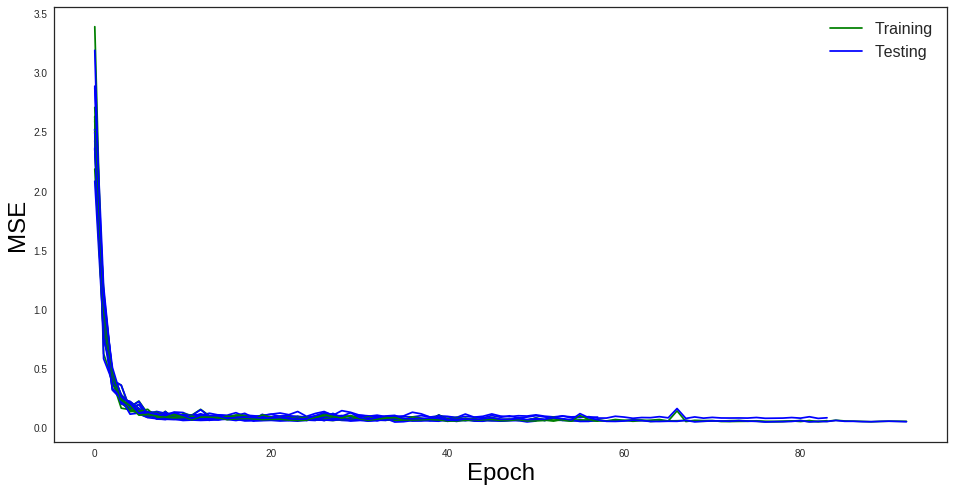

In [18]:
plt.figure(figsize=(16,8))
if cvTests:
    for i, history in enumerate(histories):
        if i == 0:
            plt.plot(history['loss'], color='g', label='Training')
            plt.plot(history['val_loss'], color='b', label='Testing')
        else:
            plt.plot(history['loss'], color='g')
            plt.plot(history['val_loss'], color='b')
    plt.legend(fontsize=16)
else:
    for history in histories:
        plt.plot(history.history['loss'])
plt.xlabel("Epoch", fontsize=24, color='black')
plt.ylabel("MSE", fontsize=24, color='black')

## Construct ensemble

In [38]:
results = None
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [39]:
def loadModel(cycle, location='train_weights/train_'):
    cycle = int(cycle)
    model = load_model(location + str(cycle) + '.h5')
    model.compile(**compileArgs)
    return model

In [40]:
def getWeights(value, met):
    return 1/value

In [41]:
ensemble = []
weights = []
print ("Choosing ensemble by", ensembleMode)
if ensembleMode == 'mix':
    for met in results[0]:
        print ("Choosing best for metric", met)
        cycle = np.argmin([result[met] for result in results])
        print (met, "Model", "is", cycle, "with", met, "=", results[cycle][met])
        ensemble.append(loadModel(cycle))
        weights.append(1)
else:
    dtype = [('cycle', int), ('result', float)]
    values = np.sort(np.array([(i, result[ensembleMode]) for i, result in enumerate(results)], dtype=dtype),
                     order=['result'])
    for i in range(min([ensembleSize, len(results)])):
        ensemble.append(loadModel(values[i]['cycle']))
        weights.append(getWeights(values[i]['result'], ensembleMode))
        print ("Model", i, "is", values[i]['cycle'], "with", ensembleMode, "=", values[i]['result'])
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Choosing ensemble by loss
Model 0 is 2 with loss = 0.0386707288979
Model 1 is 4 with loss = 0.0388981805541
Model 2 is 0 with loss = 0.0391307531764
Model 3 is 7 with loss = 0.0404718029799
Model 4 is 9 with loss = 0.0419544171618
Model 5 is 3 with loss = 0.045552949414
Model 6 is 8 with loss = 0.0458445232742
Model 7 is 1 with loss = 0.0493390618352
Model 8 is 5 with loss = 0.0543957133576
Model 9 is 6 with loss = 0.0595972846397


# Save

In [42]:
name = "weights/NN_B_Regressor_App_" + mode + "_" 
print (name)

weights/NN_B_Regressor_App_mu_tau_b_b_


In [43]:


os.system("rm " + name + "*.json")
os.system("rm " + name + "*.h5")
os.system("rm " + name + "*.pkl")
for i, model in enumerate(ensemble):
    json_string = model.to_json()
    open(name + '_' + str(i) + '.json', 'w').write(json_string) 
    model.save_weights(name + '_' + str(i) + '.h5')
with open(name + '_compile.json', 'w') as fout:
    json.dump(compileArgs, fout)
with open(name + '_weights.pkl', 'wb') as fout:
    pickle.dump(weights, fout)
with open(name + '_inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)
with open(name + '_outputPipe.pkl', 'wb') as fout:
    pickle.dump(outputPipe, fout)

## Response of ensemble on development data

###  Preprocess data

In [44]:
X_dev = inputPipe.transform(devData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [45]:
pred = np.zeros((len(devData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_dev, verbose=0)) 

In [46]:
for n, feature in enumerate(regTargetFeatures):
    devData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=devData.index)
bMass = 4.8
devData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(devData.loc[:,'reg_b_0_px'])+np.square(devData.loc[:,'reg_b_0_py'])+np.square(devData.loc[:,'reg_b_0_pz']))
devData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(devData.loc[:,'reg_b_1_px'])+np.square(devData.loc[:,'reg_b_1_py'])+np.square(devData.loc[:,'reg_b_1_pz']))
devData['reg_h_bb_px'] = devData.loc[:,'reg_b_0_px']+devData.loc[:,'reg_b_1_px']
devData['reg_h_bb_py'] = devData.loc[:,'reg_b_0_py']+devData.loc[:,'reg_b_1_py']
devData['reg_h_bb_pz'] = devData.loc[:,'reg_b_0_pz']+devData.loc[:,'reg_b_1_pz']
devData['reg_h_bb_E'] = devData.loc[:,'reg_b_0_E']+devData.loc[:,'reg_b_1_E']
devData['reg_h_bb_p2'] = np.square(devData.loc[:,'reg_h_bb_px'])+np.square(devData.loc[:,'reg_h_bb_py'])+np.square(devData.loc[:,'reg_h_bb_pz'])
devData['reg_h_bb_mass'] = np.sqrt(np.square(devData.loc[:,'reg_h_bb_E'])-devData.loc[:,'reg_h_bb_p2'])

### Evaluate response

In [47]:
devData['loss_d'] = 0
for n, feature in enumerate(regTargetFeatures):
    devData.loc[:, 'loss_d'] += np.square(devData.loc[:, 'reg_' + feature[4:]]-devData.loc[:, feature])
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(devData[:]['reg_h_bb_mass'].values, len(devData), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
print ('Ensemble on dev data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(devData.loc[:, 'loss_d'])/len(regTargetFeatures), meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))

Ensemble on dev data:
 Loss = 512.569408423, Mean = 115.484239332 +- 0.0219959034814, sigma = 13.2996273761 +- 0.0300749506119


## Response of ensemble on validation data

###  Preprocess data

In [29]:
X_val = inputPipe.transform(valData[regTrainFeatures].values.astype(theano.config.floatX))

### Get response

In [30]:
pred = np.zeros((len(valData), len(regTargetFeatures)))
for i, model in enumerate(ensemble):
    pred += weights[i]*outputPipe.inverse_transform(model.predict(X_val, verbose=0)) 

In [31]:
for n, feature in enumerate(regTargetFeatures):
    valData['reg_' + feature[4:]] = pandas.Series(pred[:,n], index=valData.index)
bMass = 4.8
valData['reg_b_0_E'] = np.sqrt((bMass**2)+np.square(valData.loc[:,'reg_b_0_px'])+np.square(valData.loc[:,'reg_b_0_py'])+np.square(valData.loc[:,'reg_b_0_pz']))
valData['reg_b_1_E'] = np.sqrt((bMass**2)+np.square(valData.loc[:,'reg_b_1_px'])+np.square(valData.loc[:,'reg_b_1_py'])+np.square(valData.loc[:,'reg_b_1_pz']))
valData['reg_h_bb_px'] = valData.loc[:,'reg_b_0_px']+valData.loc[:,'reg_b_1_px']
valData['reg_h_bb_py'] = valData.loc[:,'reg_b_0_py']+valData.loc[:,'reg_b_1_py']
valData['reg_h_bb_pz'] = valData.loc[:,'reg_b_0_pz']+valData.loc[:,'reg_b_1_pz']
valData['reg_h_bb_E'] = valData.loc[:,'reg_b_0_E']+valData.loc[:,'reg_b_1_E']
valData['reg_h_bb_p2'] = np.square(valData.loc[:,'reg_h_bb_px'])+np.square(valData.loc[:,'reg_h_bb_py'])+np.square(valData.loc[:,'reg_h_bb_pz'])
valData['reg_h_bb_mass'] = np.sqrt(np.square(valData.loc[:,'reg_h_bb_E'])-valData.loc[:,'reg_h_bb_p2'])

### Evaluate response

In [32]:
valData['loss_v'] = 0
for n, feature in enumerate(regTargetFeatures):
    valData.loc[sig, 'loss_v'] += np.square(valData.loc[sig, 'reg_' + feature[4:]]-valData.loc[sig, feature])
meanBootReg = []
stvalBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stvalBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stvalReg = (np.mean(stvalBootReg), np.std(stvalBootReg)/math.sqrt(len(stvalBootReg)))
print ('Ensemble on val data:\n Loss = {}, Mean = {} +- {}, sigma = {} +- {}'.format(np.mean(valData.loc[sig, 'loss_v'])/len(regTargetFeatures), meanReg[0], meanReg[1], stvalReg[0], stvalReg[1]))

Ensemble on val data:
 Loss = 1119.96681878, Mean = 111.59276299 +- 0.06686983758, sigma = 21.1154177505 +- 0.127787309017


### Momentum distributions

In [33]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    plt.figure(figsize=(8, 6))
    bootGen = []
    meanBootGen = []
    stdevBootGen = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature].values, len(valData[sig]), replace=True)
        meanBootGen.append(points.mean())
        stdevBootGen.append(points.std())
    meanGen = (np.mean(meanBootGen), np.std(meanBootGen)/math.sqrt(len(meanBootGen)))
    stdevGen = (np.mean(stdevBootGen), np.std(stdevBootGen)/math.sqrt(len(stdevBootGen)))
    sns.kdeplot(valData[sig][feature], label= 'True Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanGen[0], meanGen[1], stvalGen[0], stvalGen[1]))
    bootRec = []
    meanBootRec = []
    stdevBootRec = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBootRec.append(points.mean())
        stdevBootRec.append(points.std())
    meanRec = (np.mean(meanBootRec), np.std(meanBootRec)/math.sqrt(len(meanBootRec)))
    stdevRec = (np.mean(stdevBootRec), np.std(stdevBootRec)/math.sqrt(len(stdevBootRec)))
    sns.kdeplot(valData[sig][feature[4:]], label= 'Reconstructed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanRec[0], meanRec[1], stvalRec[0], stvalRec[1])))
    bootReg = []
    meanBootReg = []
    stdevBootReg = []
    for i in range(100):
        points = np.random.choice(valData[sig]["reg_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBootReg.append(points.mean())
        stdevBootReg.append(points.std())
    meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
    stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
    sns.kdeplot(valData[sig]["reg_" + feature[4:]] , label= 'Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stvalReg[0], stvalReg[1])))
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

'for n, feature in enumerate(regTargetFeatures):\n    print ()\n    print (feature)\n    plt.figure(figsize=(8, 6))\n  \n    bootGen = []\n    meanBootGen = []\n    stdevBootGen = []\n    for i in range(100):\n        points = np.random.choice(valData[sig][feature].values, len(valData[sig]), replace=True)\n        meanBootGen.append(points.mean())\n        stdevBootGen.append(points.std())\n    meanGen = (np.mean(meanBootGen), np.std(meanBootGen)/math.sqrt(len(meanBootGen)))\n    stdevGen = (np.mean(stdevBootGen), np.std(stdevBootGen)/math.sqrt(len(stdevBootGen)))\n    sns.kdeplot(valData[sig][feature])\n    bootRec = []\n    meanBootRec = []\n    stdevBootRec = []\n    for i in range(100):\n        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)\n        meanBootRec.append(points.mean())\n        stdevBootRec.append(points.std())\n    meanRec = (np.mean(meanBootRec), np.std(meanBootRec)/math.sqrt(len(meanBootRec)))\n    stdevRec = (np.mean(

In [34]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    plt.figure(figsize=(8, 6))
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[bkg][feature[4:]].values, len(valData[bkg]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[bkg][feature[4:]].values, label= 'Reconstructed Background, Mean = {} +- {}, sigma = {} +- {}'.format(mean[0], mean[1], stdev[0], stdev[1]))
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[bkg]["reg_" + feature[4:]].values, len(valData[bkg]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[bkg]["reg_" + feature[4:]].values, label= 'Regressed Background, Mean = {} +- {}, sigma = {} +- {}'.format(mean[0], mean[1], stdev[0], stdev[1]))
    boot = []
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[sig][feature[4:]].values, len(valData[sig]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[sig][feature[4:]].values, label=label= 'Reconstructed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(mean[0], mean[1], stdev[0], stdev[1]))
    boot = [];
    meanBoot = []
    stdevBoot = []
    for i in range(100):
        points = np.random.choice(valData[sig]["reg_" + feature[4:]].values, len(valData[sig]), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    sns.kdeplot(data=valData[sig]["reg_" + feature[4:]].values, label=label= 'Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(mean[0], mean[1], stdev[0], stdev[1]))
    plt.legend(fontsize=16)
    var = "p_{x,b_0}"
    if "py" in feature:
        var = "p_{y,b_0}"
    if "pz" in feature:
        var = "p_{z,b_0}"
    if "_1_" in feature:
        var = var[:-2] + "1}"
    plt.xlabel(r"$" + var + r"\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d" + var + r"}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

'for n, feature in enumerate(regTargetFeatures):\n    print ()\n    print (feature)\n    plt.figure(figsize=(8, 6))\n    boot = []\n    meanBoot = []\n    stdevBoot = []\n    for i in range(100):\n        points = np.random.choice(valData[bkg][feature[4:]].values, len(valData[bkg]), replace=True)\n        meanBoot.append(points.mean())\n        stdevBoot.append(points.std())\n    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))\n    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))\n    sns.kdeplot(data=valData[bkg][feature[4:]].values, label=\'bkg reco\')\n    boot = []\n    meanBoot = []\n    stdevBoot = []\n    for i in range(100):\n        points = np.random.choice(valData[bkg]["reg_" + feature[4:]].values, len(valData[bkg]), replace=True)\n        meanBoot.append(points.mean())\n        stdevBoot.append(points.std())\n    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))\n    stdev = (np.mean(stdevBoot), np.std(stdev

### Momentum pull distributions

In [35]:
print ("\tFeature\tmean\t\t\t\t\t\tsigma")
for n, feature in enumerate(regTargetFeatures):
    plt.figure(figsize=(8, 6))
    
    var = "p_{x,b_0"
    if "py" in feature:
        var = "p_{y,b_0"
    if "pz" in feature:
        var = "p_{z,b_0"
    if "_1_" in feature:
        var = var[:-1] + "1"
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig][feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print ("Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=pullVal, label= 'Reconstructed, Mean = {} +- {}, sigma = {} +- {}'.format(mean[0], mean[1], stdev[0], stdev[1]), gridsize=500)
    boot = []
    meanBoot = []
    stdevBoot = []
    pullVal = valData[sig]['reg_' + feature[4:]].values-valData[sig][feature].values
    for i in range(100):
        points = np.random.choice(pullVal, len(pullVal), replace=True)
        meanBoot.append(points.mean())
        stdevBoot.append(points.std())
       
    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))
    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))
    print ("Reg:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))
    sns.kdeplot(data=pullVal, label= 'Regressed, Mean = {} +- {}, sigma = {} +- {}'.format(mean[0], mean[1], stdev[0], stdev[1]), gridsize=500)
    plt.legend(fontsize=16)
    plt.xlabel(r"$" + var + r",\mathrm{Est.}}-" + var + r",\mathrm{True}}\ [GeV]$", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\Delta " + var + r"}}\ [GeV^{-1}]$", fontsize=24, color='black')
    plt.xlim(-100,100)
plt.show()

'print ("\tFeature\tmean\t\t\t\t\t\tsigma")\nfor n, feature in enumerate(regTargetFeatures):\n    plt.figure(figsize=(8, 6))\n    \n    var = "p_{x,b_0"\n    if "py" in feature:\n        var = "p_{y,b_0"\n    if "pz" in feature:\n        var = "p_{z,b_0"\n    if "_1_" in feature:\n        var = var[:-1] + "1"\n    boot = []\n    meanBoot = []\n    stdevBoot = []\n    pullVal = valData[sig][feature[4:]].values-valData[sig][feature].values\n    for i in range(100):\n        points = np.random.choice(pullVal, len(pullVal), replace=True)\n        meanBoot.append(points.mean())\n        stdevBoot.append(points.std())\n    mean = (np.mean(meanBoot), np.std(meanBoot)/math.sqrt(len(meanBoot)))\n    stdev = (np.mean(stdevBoot), np.std(stdevBoot)/math.sqrt(len(stdevBoot)))\n    print ("Reco:\t{}\t{} +- {}\t{} +- {}".format(feature[4:], mean[0], mean[1], stdev[0], stdev[1]))\n    sns.kdeplot(data=pullVal, label=\'reconstructed\', gridsize=500)\n    boot = []\n    meanBoot = []\n    stdevBoot = []

### Two-sample Kolmogorov–Smirnov test

In [36]:
for n, feature in enumerate(regTargetFeatures):
    print ()
    print (feature)
    ksTest = ks_2samp(valData[sig][feature].values, valData[sig]['reg_' + feature[4:]].values)
    print ("K-S test result {0:.4f}, p-value of {1:.4f}".format(ksTest[0], ksTest[1]))


gen_b_0_px
K-S test result 0.0173, p-value of 0.9990

gen_b_0_py
K-S test result 0.0216, p-value of 0.9812

gen_b_0_pz
K-S test result 0.0324, p-value of 0.7099

gen_b_1_px
K-S test result 0.0183, p-value of 0.9975

gen_b_1_py
K-S test result 0.0270, p-value of 0.8848

gen_b_1_pz
K-S test result 0.0367, p-value of 0.5536


### Higgs mass distribution

In [37]:
bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice(valData[sig]['reg_h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice(valData[sig]['h_bb_mass'].values, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
    
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print ("Distribution\t\tmean\tsigma")
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print ('Reconstructed Signal,  Mean = {:.2f} +- {:.2f}, sigma = {:.2f} +- {:.2f}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Distribution		mean	sigma
Regressed Signal, Mean = 111.638692422 +- 0.0702972030182, sigma = 21.166521586 +- 0.124024058244
Reconstructed Signal,  Mean = 112.42 +- 0.09, sigma = 26.95 +- 0.33


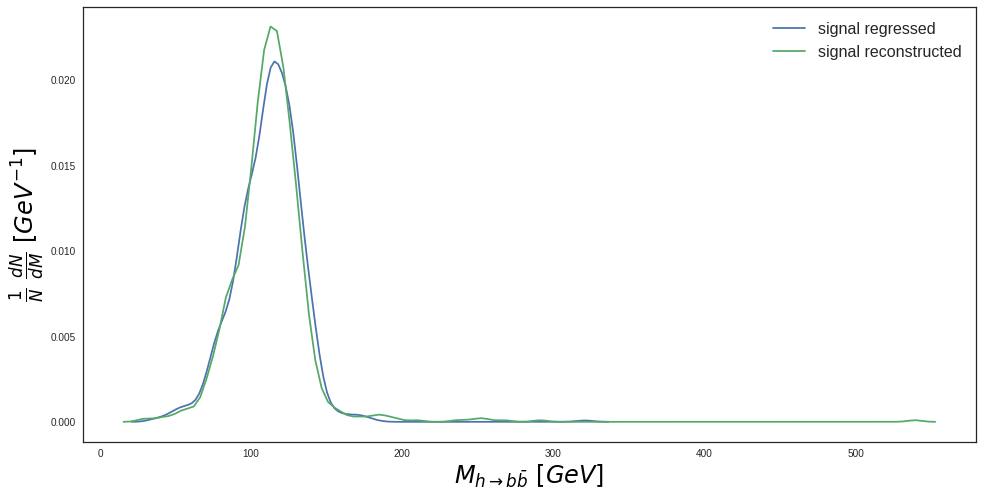

In [38]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData[sig]['reg_h_bb_mass'].values, label='Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
sns.kdeplot(data=valData[sig]['h_bb_mass'].values, label='Reconstructed Signal,  Mean = {:.2f} +- {:.2f}, sigma = {:.2f} +- {:.2f}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))
plt.legend(fontsize=16)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [39]:
bootReg = []
meanBootReg = []
stdevBootReg = []
for i in range(100):
    points = np.random.choice((valData[sig]['reg_h_bb_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReg.append(points.mean())
    stdevBootReg.append(points.std())
meanReg = (np.mean(meanBootReg), np.std(meanBootReg)/math.sqrt(len(meanBootReg)))
stdevReg = (np.mean(stdevBootReg), np.std(stdevBootReg)/math.sqrt(len(stdevBootReg)))
bootReco = []
meanBootReco = []
stdevBootReco = []
for i in range(100):
    points = np.random.choice((valData[sig]['h_bb_mass'].values-125)/125, len(valData[sig]), replace=True)
    meanBootReco.append(points.mean())
    stdevBootReco.append(points.std())
meanReco = (np.mean(meanBootReco), np.std(meanBootReco)/math.sqrt(len(meanBootReco)))
stdevReco = (np.mean(stdevBootReco), np.std(stdevBootReco)/math.sqrt(len(stdevBootReco)))
print ("Distribution\t\tmean\tsigma")
print ('Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
print ('Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))

Distribution		mean	sigma
Regressed Signal, Mean = -0.107612540693 +- 0.000582040845805, sigma = 0.171447997445 +- 0.000993624945986
Reconstructed Signal,  Mean = -0.100663144385 +- 0.000635248717374, sigma = 0.213059494048 +- 0.00264972704498


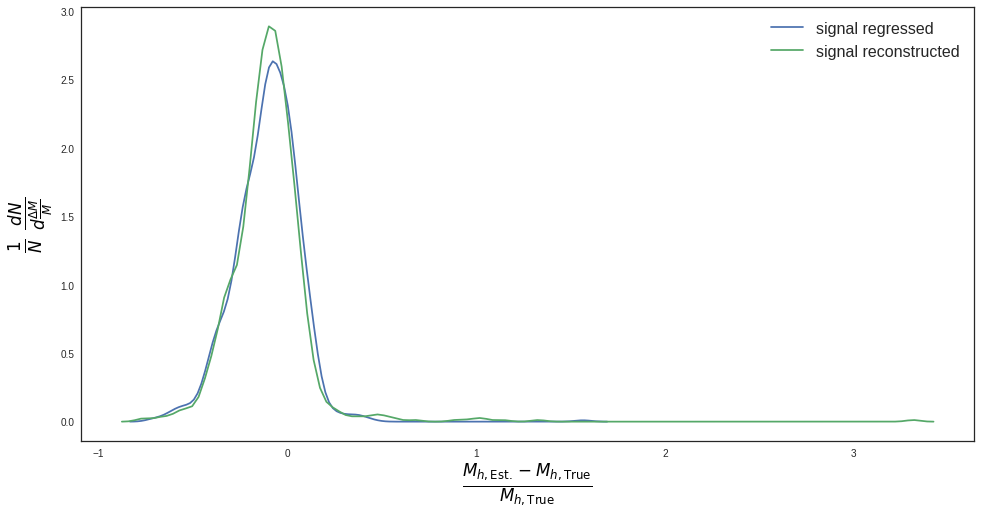

In [40]:
hist_params = {'shade' : False}
plt.figure(figsize=(16, 8))
sns.kdeplot(data=(valData[sig]['reg_h_bb_mass'].values-125)/125, label='Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]))
sns.kdeplot(data=(valData[sig]['h_bb_mass'].values-125)/125, label='Reconstructed Signal,  Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]))
plt.legend(fontsize=16)
plt.xlabel(r"$\frac{M_{h,\mathrm{Est.}}-M_{h,\mathrm{True}}}{M_{h,\mathrm{True}}}$", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d\frac{\Delta M}{M}}$", fontsize=24, color='black')
plt.show()

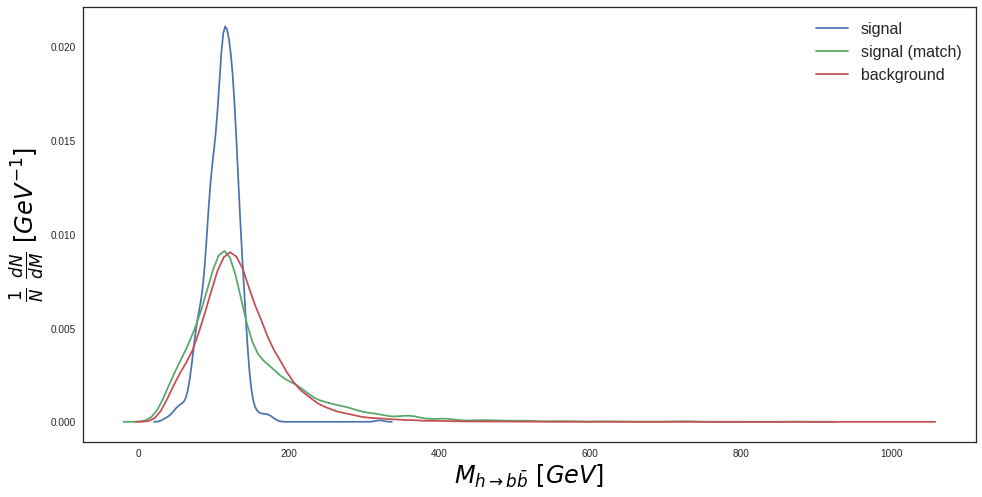

In [41]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData[sig]['reg_h_bb_mass'].values, label = 'signal')
sns.kdeplot(data=valData[sigMM]['reg_h_bb_mass'].values, label = 'signal (match)')
sns.kdeplot(data=valData[bkg]['reg_h_bb_mass'].values, label = 'background')

plt.legend(fontsize=16)

plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

In [ ]:
xPlot = np.linspace(0, 300, 300)[:, np.newaxis]
plots = mpRun([{'data':valData.loc[bkg, 'h_bb_mass'], 'x':xPlot, 'name':'bkg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[bkg, 'reg_h_bb_mass'], 'x':xPlot, 'name':'bkg_reg', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'h_bb_mass'], 'x':xPlot, 'name':'sig', 'kde':1, 'mean':1, 'std':1},
               {'data':valData.loc[sig, 'reg_h_bb_mass'], 'x':xPlot, 'name':'sig_reg', 'kde':1, 'mean':1, 'std':1}])



In [ ]:
meanReco = (np.mean(plots['sig' + '_mean']),
            np.std(plots['sig' + '_mean'])/math.sqrt(len(plots['sig' + '_mean'])))
stdReco = (np.mean(plots['sig' + '_std']),
             np.std(plots['sig' + '_std'])/math.sqrt(len(plots['sig' + '_std'])))
meanReg = (np.mean(plots['sig_reg' + '_mean']),
            np.std(plots['sig_reg' + '_mean'])/math.sqrt(len(plots['sig_reg' + '_mean'])))
stdReg = (np.mean(plots['sig_reg' + '_std']),
             np.std(plots['sig_reg' + '_std'])/math.sqrt(len(plots['sig_reg' + '_std'])))

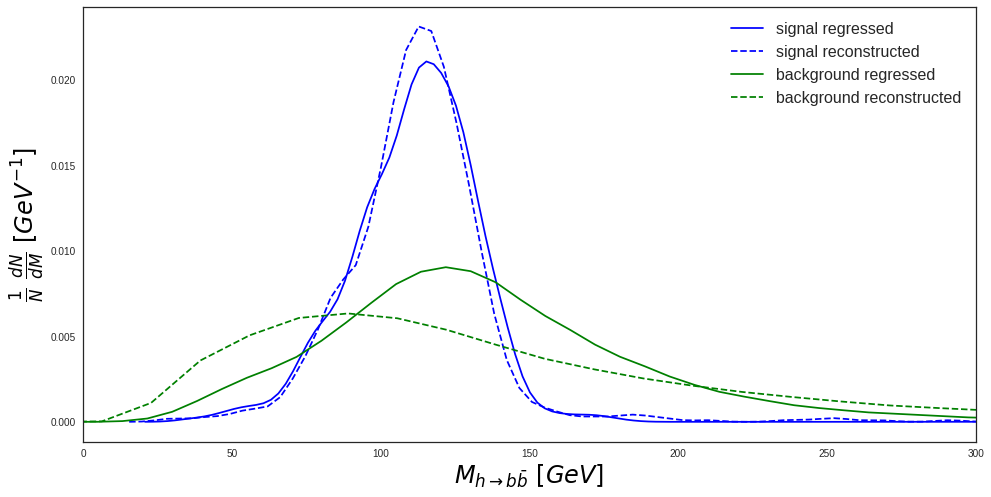

In [44]:
plt.figure(figsize=(16, 8))
sns.kdeplot(data=valData.loc[sig, 'reg_h_bb_mass'].values, label=label='Regressed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReg[0], meanReg[1], stdevReg[0], stdevReg[1]), color = 'blue')
sns.kdeplot(data=valData.loc[sig, 'h_bb_mass'].values, label=label='Reconstructed Signal, Mean = {} +- {}, sigma = {} +- {}'.format(meanReco[0], meanReco[1], stdevReco[0], stdevReco[1]), color = 'blue' , ls = 'dashed')

sns.kdeplot(data=valData.loc[bkg, 'reg_h_bb_mass'].values, label='background regressed', color = 'green' )
sns.kdeplot(data=valData.loc[bkg, 'h_bb_mass'].values, label='background reconstructed', color = 'green', ls = 'dashed')

plt.legend(fontsize=16)
plt.xlim(0,300)
plt.xlabel(r'$M_{h\rightarrow b\bar{b}}\ [GeV]$' , fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{d M}\ [GeV^{-1}]$", fontsize=24, color='black')
plt.show()

### ROC Curve

In [45]:
print ('Reg:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], -np.abs(125-valData.loc[sig|bkg, 'reg_h_bb_mass'])))
print ('Reco:', roc_auc_score(valData.loc[sig|bkg, 'gen_target'], -np.abs(125-valData.loc[sig|bkg, 'h_bb_mass'])))

Reg: 0.704041364325
Reco: 0.802008823919


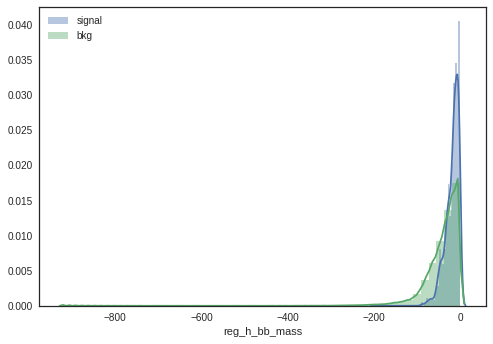

In [46]:
sns.distplot(-np.abs(125-valData.loc[sig, 'reg_h_bb_mass']), label='signal')
sns.distplot(-np.abs(125-valData.loc[bkg, 'reg_h_bb_mass']), label='bkg')
plt.legend()

## Classifier response

### Train

In [47]:
classFeatures = ['b_0_mass', 'b_1_mass', 't_0_mass', 't_1_mass', 't_0_px', 't_0_py', 't_0_pz', 't_1_px', 't_1_py', 't_1_pz', 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 'mPT_px', 'mPT_py', 'b_0_|p|', 'b_0_E', 'b_1_|p|', 'b_1_E', 't_0_|p|', 't_0_E', 't_1_|p|', 't_1_E', 'diH_mass', 'h_tt_mass', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'diH_px', 'diH_py', 'diH_pz', 'diH_|p|', 'diH_E', 'h_bb_|p|', 'h_bb_E', 'h_tt_|p|', 'h_tt_E', 'hl_mT']

In [48]:
recoFeatures = ['h_bb_mass']#, 'b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['h_bb_mass']
#recoFeatures = ['b_0_px', 'b_0_py', 'b_0_pz', 'b_1_px', 'b_1_py', 'b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['h_bb_mass']
recoFeatures = classFeatures + ['h_bb_mass']
recoClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
recoClass.fit(valData[recoFeatures], valData['gen_target'].values.astype('int'))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=-999.0, n_estimators=100,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
%%time
regFeatures = ['reg_h_bb_mass']#, 'reg_b_0_px', 'reg_b_0_py', 'reg_b_0_pz', 'reg_b_1_px', 'reg_b_1_py', 'reg_b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['reg_h_bb_mass']
#regFeatures = ['reg_b_0_px', 'reg_b_0_py', 'reg_b_0_pz', 'reg_b_1_px', 'reg_b_1_py', 'reg_b_1_pz']#, 'h_tt_mass', 'diH_mass'] #classFeatures + ['reg_h_bb_mass']
regFeatures = classFeatures + ['reg_h_bb_mass']
regClass = xgb.XGBClassifier(base_score=0.5, learning_rate=0.3,
         gamma=0, max_depth=6, missing=-999.0, n_estimators=100, random_state=0,n_jobs=8)
regClass.fit(valData[regFeatures], valData['gen_target'].values.astype('int'))

CPU times: user 5min 22s, sys: 1.04 s, total: 5min 23s
Wall time: 41 s


### Test

In [50]:
recoPred = recoClass.predict_proba(valData[recoFeatures])[:,1]

In [51]:
regPred = regClass.predict_proba(valData[regFeatures])[:,1]

In [52]:
recoAUC = roc_auc_score(valData['gen_target'].values, recoPred)
regAUC = roc_auc_score(valData['gen_target'].values, regPred)

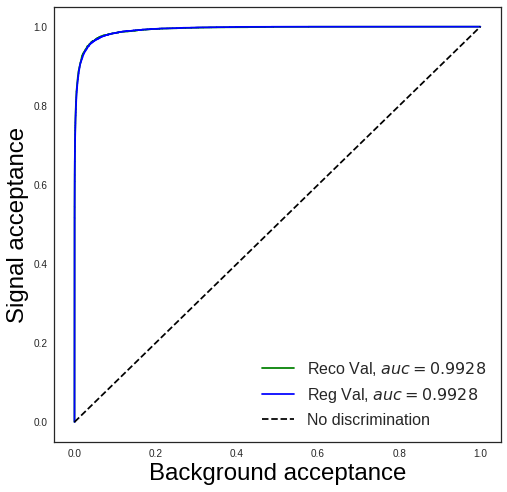

In [53]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, recoPred)[:2],
         label=r'Reco Val, $auc={:.4f}$'.format(recoAUC), color='g')
plt.plot(*roc_curve(valData['gen_target'].values, regPred)[:2],
         label=r'Reg Val, $auc={:.4f}$'.format(regAUC), color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

## Load

In [54]:
ensemble = []
weights = None
inputPipe = None
outputPipe = None
compileArgs = None
with open(name + '_compile.json', 'r') as fin:
    compileArgs = json.load(fin)
for i in range(ensembleSize):
    model = model_from_json(open(name + '_' + str(i) + '.json').read())
    model.load_weights(name + "_" + str(i) + '.h5')
    model.compile(**compileArgs)
    ensemble.append(model)
with open(name + '_weights.pkl', 'rb') as fin:
    weights = pickle.load(fin)
with open(name + '_inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)
with open(name + '_outputPipe.pkl', 'rb') as fin:
    outputPipe = pickle.load(fin)